In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

   id  N_Days             Drug      Age Sex Ascites Hepatomegaly Spiders  \
0   0  1481.0          Placebo  12963.0   F       N            Y       N   
1   1  2580.0  D-penicillamine  20819.0   F       N            N       N   
2   2   837.0  D-penicillamine  12307.0   F       N            Y       Y   
3   3  3021.0              NaN  17532.0   F     NaN          NaN     NaN   
4   4  1980.0              NaN  23011.0   F     NaN          NaN     NaN   

  Edema  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  \
0     N        2.4        346.0     3.34    70.0    1212.0  122.45   
1     N        0.6          NaN     4.52    51.0     645.0   74.40   
2     N        6.1        586.0     2.73    89.0    2045.0  196.85   
3     N        0.6          NaN     3.34     NaN       NaN     NaN   
4     N        0.8          NaN     3.65     NaN       NaN     NaN   

   Tryglicerides  Platelets  Prothrombin  Stage Status  
0          118.0      117.0         12.2    4.0      C  
1       

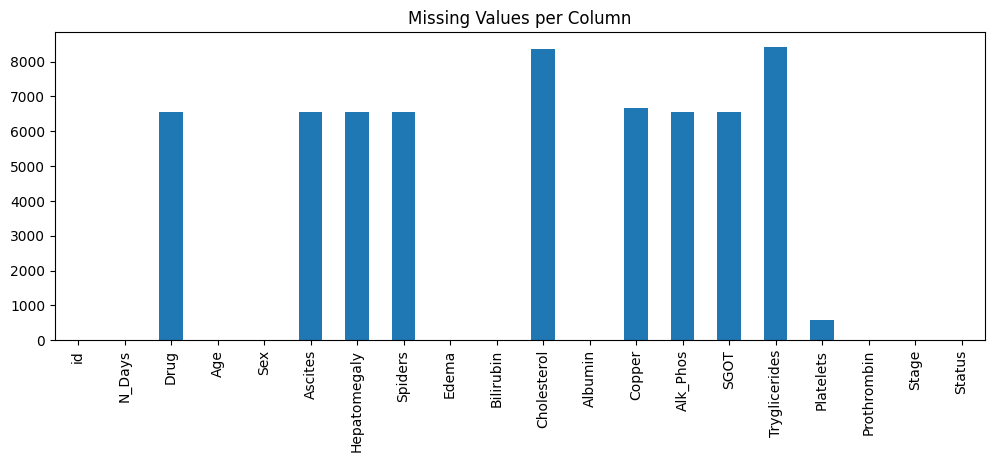

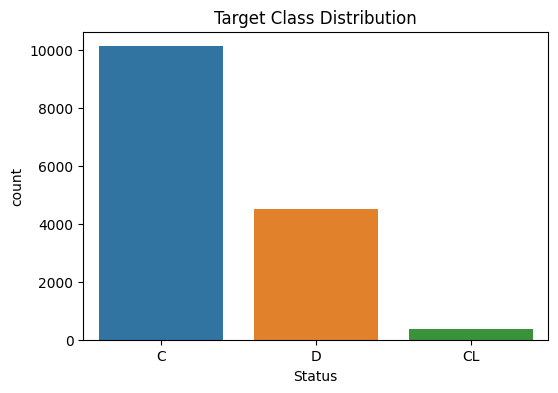

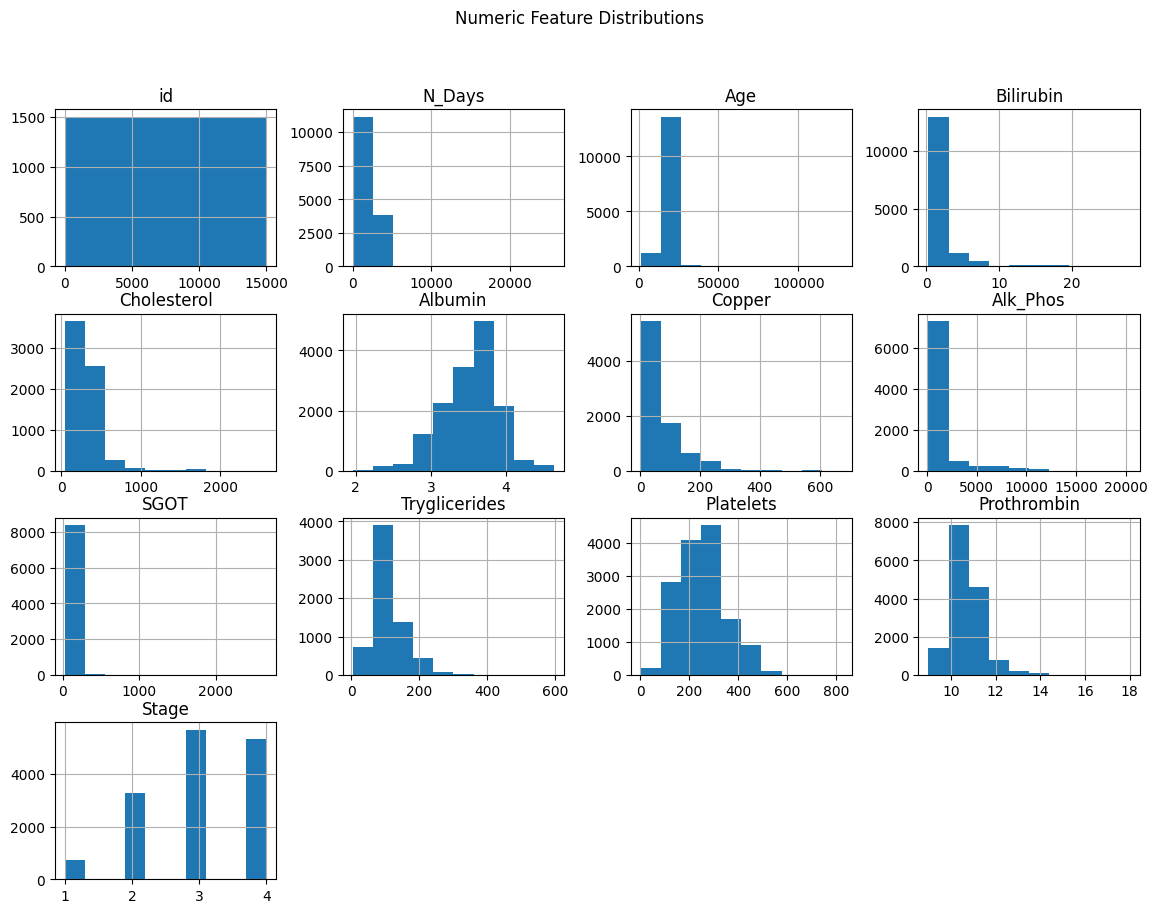

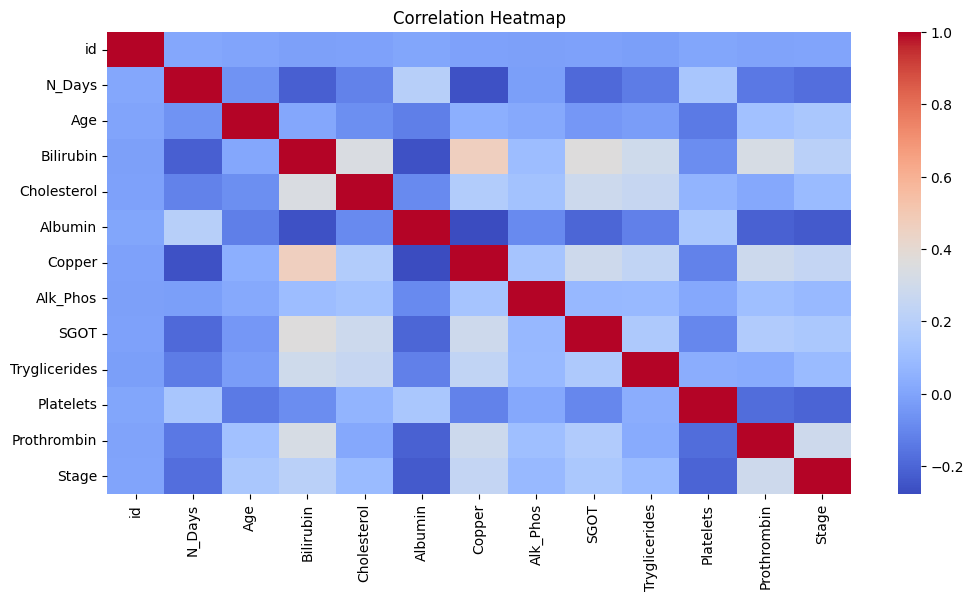

Label Mapping: ['C' 'CL' 'D']
Accuracy : 0.8443333333333334
Precision: 0.7211116786053973
Recall   : 0.5539360471683381
F1 Score : 0.5600333478498748
ROC AUC  : 0.8989420514067467
Duplicate IDs: 0
submission6.csv CREATED SUCCESSFULLY!


,id,Status_C,Status_CL,Status_D
0,15000,0.906667,0.006667,0.086667
1,15001,0.920000,0.000000,0.080000
2,15002,0.763333,0.116667,0.120000
3,15003,0.230000,0.083333,0.686667
4,15004,0.923333,0.006667,0.070000


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ================================
# 1. LOAD DATA
# ================================
train = pd.read_csv("/kaggle/input/mock-test-2-mse-2/train.csv")
test = pd.read_csv("/kaggle/input/mock-test-2-mse-2/test.csv")

print(train.head())
print(train.info())
print(train.isnull().sum())
print(train['Status'].value_counts())

# ================================
# 2. SEPARATE FEATURES & TARGET
# ================================
y = train["Status"]
X = train.drop("Status", axis=1)

num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

# ================================
# 3. VISUALIZATION & EDA GRAPHICS
# ================================

plt.figure(figsize=(12,4))
train.isnull().sum().plot(kind='bar')
plt.title("Missing Values per Column")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x=train['Status'])
plt.title("Target Class Distribution")
plt.show()

# Numeric distributions
X[num_cols].hist(figsize=(14,10))
plt.suptitle("Numeric Feature Distributions")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12,6))
sns.heatmap(X[num_cols].corr(), cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# ================================
# 4. HANDLE NULL VALUES
# ================================
X[num_cols] = X[num_cols].fillna(X[num_cols].median())
test[num_cols] = test[num_cols].fillna(test[num_cols].median())

X[cat_cols] = X[cat_cols].fillna(X[cat_cols].mode().iloc[0])
test[cat_cols] = test[cat_cols].fillna(test[cat_cols].mode().iloc[0])

# ================================
# 5. FIX DUPLICATE ID ISSUES
# ================================
X = X.reset_index(drop=True)
test = test.reset_index(drop=True)

# ================================
# 6. LABEL ENCODE TARGET
# ================================
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Label Mapping:", le.classes_)  # ['C', 'CL', 'D']

# ================================
# 7. ONEHOT ENCODING + MODEL PIPELINE
# ================================
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42
    ))
])

# ================================
# 8. TRAIN/VALID SPLIT
# ================================
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# ================================
# 9. TRAIN MODEL
# ================================
model.fit(X_train, y_train)

# ================================
# 10. EVALUATE MODEL
# ================================
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)

print("Accuracy :", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred, average='macro'))
print("Recall   :", recall_score(y_val, y_pred, average='macro'))
print("F1 Score :", f1_score(y_val, y_pred, average='macro'))
print("ROC AUC  :", roc_auc_score(y_val, y_prob, multi_class='ovr'))

# ================================
# 11. TRAIN FULL MODEL ON ALL DATA
# ================================
model.fit(X, y_encoded)

# ================================
# 12. PREDICT TEST SET
# ================================
test_pred = model.predict_proba(test)

# ================================
# 13. CREATE KAGGLE SUBMISSION
# ================================
submission = pd.DataFrame({
    "id": test["id"],
    "Status_C":  test_pred[:, le.transform(['C'])[0]],
    "Status_CL": test_pred[:, le.transform(['CL'])[0]],
    "Status_D":  test_pred[:, le.transform(['D'])[0]],
})

print("Duplicate IDs:", submission["id"].duplicated().sum())  # MUST BE 0

submission.to_csv("submission6.csv", index=False)
print("submission6.csv CREATED SUCCESSFULLY!")
submission.head()


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# --------------------------------------------------------
# 1. LOAD DATA
# --------------------------------------------------------
train_path = "/kaggle/input/mock-test-2-mse-2/train.csv"   # <-- PUT YOUR TRAIN CSV HERE
test_path = "/kaggle/input/mock-test-2-mse-2/test.csv"     # <-- PUT YOUR TEST CSV HERE

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# --------------------------------------------------------
# 2. SEPARATE FEATURES & TARGET
# --------------------------------------------------------
y = train_df["Status"]           # Your correct target
X = train_df.drop(columns=["Status"])

test_ids = test_df["id"]         # required for submission
X_test = test_df.copy()

# --------------------------------------------------------
# 3. IDENTIFY COLUMN TYPES
# --------------------------------------------------------
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

# Remove id from both
if "id" in num_cols: 
    num_cols.remove("id")
if "id" in cat_cols:
    cat_cols.remove("id")

# --------------------------------------------------------
# 4. PREPROCESSING PIPELINE
# --------------------------------------------------------
numeric_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols)
    ]
)

# --------------------------------------------------------
# 5. FINAL MODEL (Random Forest)
# --------------------------------------------------------
model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced"
    ))
])

# --------------------------------------------------------
# 6. TRAIN/VALIDATION SPLIT
# --------------------------------------------------------
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --------------------------------------------------------
# 7. TRAIN MODEL
# --------------------------------------------------------
model.fit(X_train, y_train)

# --------------------------------------------------------
# 8. VALIDATION CHECK
# --------------------------------------------------------
y_pred = model.predict(X_valid)
from sklearn.metrics import accuracy_score
print("Validation Accuracy:", accuracy_score(y_valid, y_pred))

# --------------------------------------------------------
# 9. PREDICT PROBABILITIES FOR TEST
# --------------------------------------------------------
probs = model.predict_proba(X_test)

# Order of classes (VERY IMPORTANT)
class_order = model.named_steps["rf"].classes_
print("Model class order:", class_order)

# --------------------------------------------------------
# 10. BUILD SUBMISSION CSV
# --------------------------------------------------------
submission = pd.DataFrame()
submission["id"] = test_ids

# Fill probability columns in required order C, CL, D
submission["Status_C"]  = probs[:, list(class_order).index("C")]
submission["Status_CL"] = probs[:, list(class_order).index("CL")]
submission["Status_D"]  = probs[:, list(class_order).index("D")]

# Save final CSV
submission.to_csv("submission.csv", index=False)

print("Submission file created: submission.csv")

Validation Accuracy: 0.849
Model class order: ['C' 'CL' 'D']
Submission file created: submission.csv
